In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium==4.9.1

Executing: /tmp/apt-key-gpghome.ADmqxH9hGA/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.hKX5er5Hht/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.GCc4AgWZSF/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian bust

In [ ]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from tqdm.notebook import tqdm
import pandas
import json
import pprint
import pandas as pd
import urllib.parse
import re
import numpy as np
import datetime


from google.colab import drive
drive.mount('/content/drive')

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("window-size=1900,800")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

Mounted at /content/drive


In [1]:
import sys
import logging
import calendar
from tqdm.notebook import tqdm
import pandas
import json
import pprint
import pandas as pd
import urllib.parse
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from matplotlib.ticker import FuncFormatter
drive.mount('/content/drive')

Mounted at /content/drive


## Scraper qualità aria

In [ ]:
wd = webdriver.Chrome('chromedriver', options=chrome_options)
df_all = pd.DataFrame()
for date in pd.date_range(start='1/1/2013', end = datetime.datetime.now()):
  print(date.date())
  wd.get(f"https://www.amat-mi.it/index.php?id_sezione=35&data_bollettino={date.date()}")

  list_text=wd.find_elements(By.CLASS_NAME, "NOtable-responsive")[0].text.split('\n')

  start = np.where('[μg/m3]' == np.array(list_text))[0][0]+1
  end = np.where(['Parametro calcolato' in i for i in  np.array(list_text)])[0][0]-1
  arr = []
  for line in list_text[start:end]:
    split=line.replace('*','').replace('< ','<').replace('> ','>').split(' ')
    arr.append([' '.join(split[:-7])]+ split[-7:])
  print(arr)
  df = pd.DataFrame(arr)
  df['date']=date
  df_all = pd.concat([df,df_all])
  df_all.to_csv('/content/drive/MyDrive/aria.csv',index=False)

In [2]:
air = pd.read_csv('/content/drive/MyDrive/aria.csv')
vars = ['loc','SO2','PM10','PM25','NO2','CO','O3','C6H6']
for i in [1,2,3,4,5,6,7]:
  air[str(i)]=air[str(i)].str.replace('<','').str.replace('>','').str.replace(',','.').replace(['-','N.D.'],None)
  air[str(i)]=air[str(i)].astype(float)

air=air.rename(columns={str(i):vars[i] for i in range(8)})
air['date']=air['date'].astype('datetime64')

In [5]:
air.head()

,loc,SO2,PM10,PM25,NO2,CO,O3,C6H6,date
0,Viale Liguria,NaN,NaN,NaN,52.0,0.5,NaN,NaN,2023-07-27
1,Viale Marche,NaN,5.0,4.0,NaN,0.5,NaN,1.0,2023-07-27
2,Via Pascal,5.0,5.0,3.0,25.0,NaN,85.0,1.0,2023-07-27
3,Via Senato,NaN,NaN,NaN,40.0,0.5,NaN,1.1,2023-07-27
4,Viale Liguria,NaN,NaN,NaN,57.0,0.5,NaN,NaN,2023-07-26


In [3]:
air_avgloc=air.groupby('date').mean(numeric_only=True).reset_index()
air_yearavg = air_avgloc.groupby(air_avgloc.date.dt.strftime('%m/%d')).mean(numeric_only=True).drop('02/29').reset_index()
air_yearavg.date = air_yearavg.date.apply(lambda x: datetime.date(month=int(x.split('/')[0]),day=int(x.split('/')[1]),year=2000)).astype('datetime64')
air_smooth = air_yearavg.set_index('date').rolling(pd.Timedelta(days=30)).mean().sort_index()

## Import accessi area C

In [7]:
files=['2013','2014','2015','2016','2016-2018','2019-']
accessi=pd.DataFrame()
for i in files:
  df=pd.DataFrame(pd.read_csv(f'/content/drive/MyDrive/accessi_{i}.csv',delimiter=';').iloc[:,:2].values, columns=['date','access'])
  accessi=pd.concat([accessi, df])
accessi.date=accessi.date.str[:10].astype('datetime64')

In [9]:
accessi_yearavg = accessi.groupby(accessi.date.dt.strftime('%m/%d')).access.mean().drop('02/29').reset_index()
accessi_yearavg.date = accessi_yearavg.date.apply(lambda x: datetime.date(month=int(x.split('/')[0]),day=int(x.split('/')[1]),year=2000)).astype('datetime64')
accessi_smooth = accessi_yearavg.set_index('date').rolling(pd.Timedelta(days=30)).mean().sort_index()

In [8]:
accessi.head()

,date,access
0,2013-01-01,74186
1,2013-01-02,97080
2,2013-01-03,108552
3,2013-01-04,115900
4,2013-01-05,124562


## PLOT

<ipython-input-12-3c0c6483c370>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-12-3c0c6483c370>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-12-3c0c6483c370>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


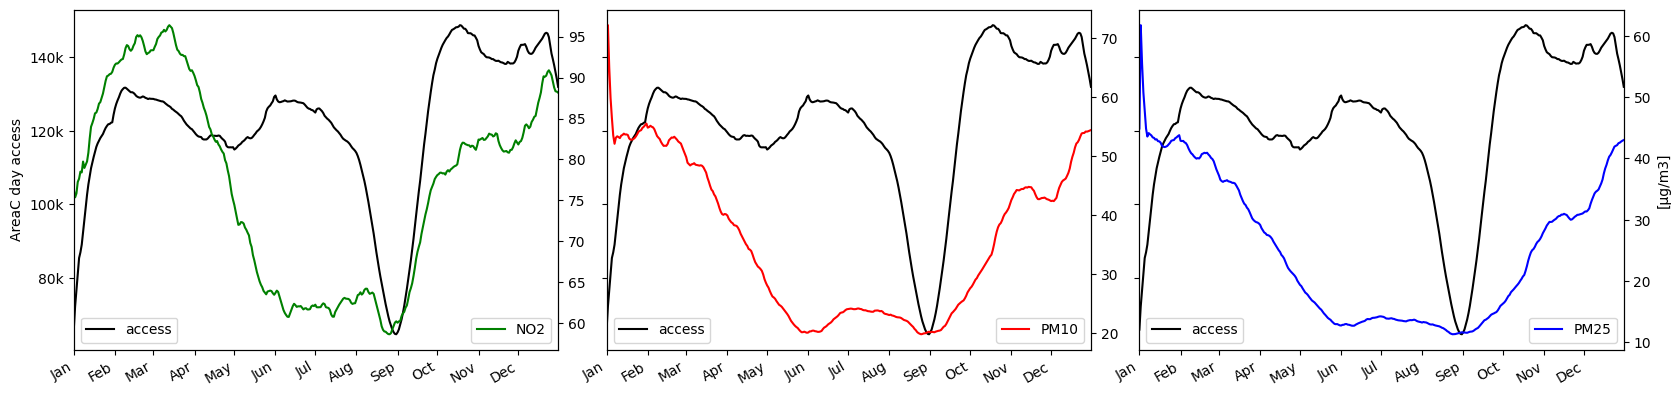

In [12]:
fig, axs = plt.subplots(1,3,figsize=(20,5),sharey='row')
plt.subplots_adjust(wspace=.1)

for ax, var, color in zip(axs, ['NO2','PM10','PM25'],['green','red','blue']):
  accessi_smooth.reset_index().plot(x='date',y='access',ax=ax,color='black',label='access')
  ax.set_xlim(datetime.date.fromisoformat('2000-01-01'),datetime.date.fromisoformat('2000-12-31'))
  ax.set_ylabel('AreaC day access',color='black')
  ax.legend(loc='lower left')
  labels = [calendar.month_abbr[ int(item.get_text().split('-')[1])] for item in ax.get_xticklabels()]
  ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: str(int(x/1000))+ 'k'))
  ax.set_xticklabels(labels)
  ax2=ax.twinx()
  ax.set_xlabel('')
  if var == 'PM25':
    ax2.set_ylabel('[μg/m3]')
  else:
    ax2.set_ylabel('')
  air_smooth.reset_index().plot(x='date',y=var,ax=ax2, color=color)
  ax2.legend(loc='lower right')
fig.savefig('/content/drive/MyDrive/fig1.png')

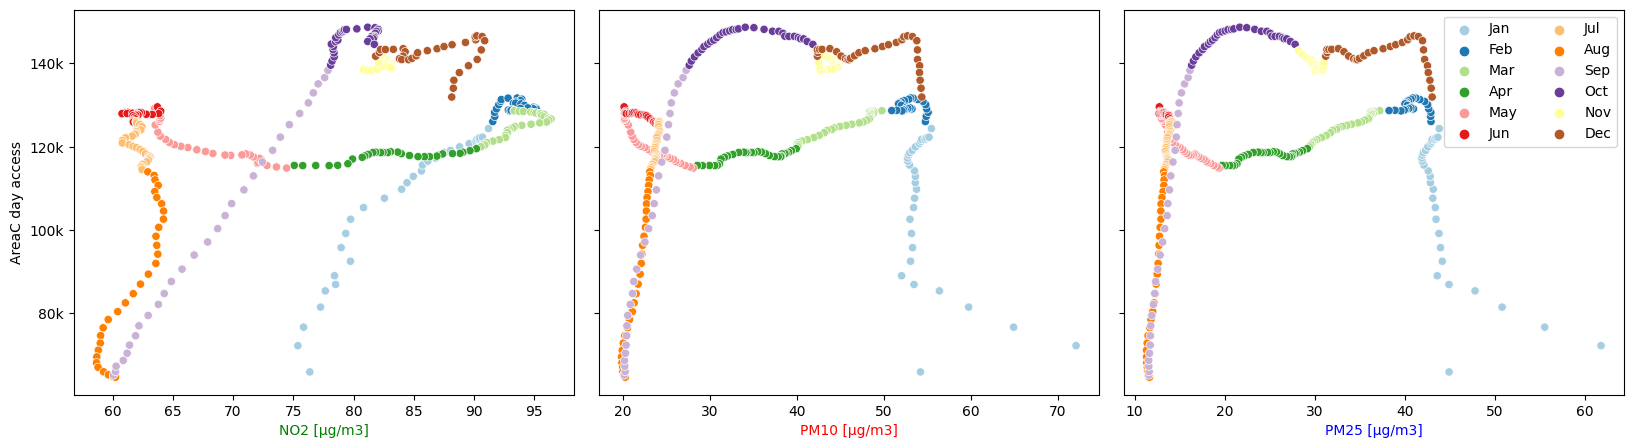

In [13]:
fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True)
plt.subplots_adjust(wspace=.05)

for ax, var, color in zip(axs, ['NO2','PM10','PM25'],['green','red','blue']):

  merge=air_smooth.merge(accessi_smooth,on='date').reset_index()
  merge['month']=merge.date.dt.month.apply(lambda x: calendar.month_abbr[x])
  ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: str(int(x/1000))+ 'k'))
  sns.scatterplot(merge ,x=var,y='access',hue='month',legend='full' if var=='PM25' else False ,palette='Paired', ax=ax)
  ax.set_xlabel(var+' [μg/m3]',color=color)
  if var=='PM25':
    ax.legend(ncol=2)
  ax.set_ylabel('AreaC day access')
fig.savefig('/content/drive/MyDrive/fig2.png')
